## Monkeypox differential diagnosis using a Modified Xception Model

Monkeypox images are compared to 'Chickenpox' and 'Measles' skin leasions because of their resemblance to the monkeypox rash and pustules in initial state.
Most of the images provided were augmented images therefore they were used for training but for validation true images were chosen

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Add
from tensorflow.keras.layers import SeparableConv2D, ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

print("TF version:", tf.__version__)

TF version: 2.6.4


### Loading and Processing the data

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory("../input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train",    
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(299, 299),
    shuffle=True,
    seed=42,                                                   
    validation_split=0.2,
    subset="training",                                                  
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
 )

Found 2142 files belonging to 2 classes.
Using 1714 files for training.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory("../input/monkeypox-skin-lesion-dataset/Original Images/Original Images",
  validation_split=None,
  seed=123,
  image_size=(299, 299),
  batch_size=32)

Found 228 files belonging to 2 classes.


In [4]:
class_names = train_ds.class_names
print(class_names)

['Monkeypox', 'Others']


### Previewing images

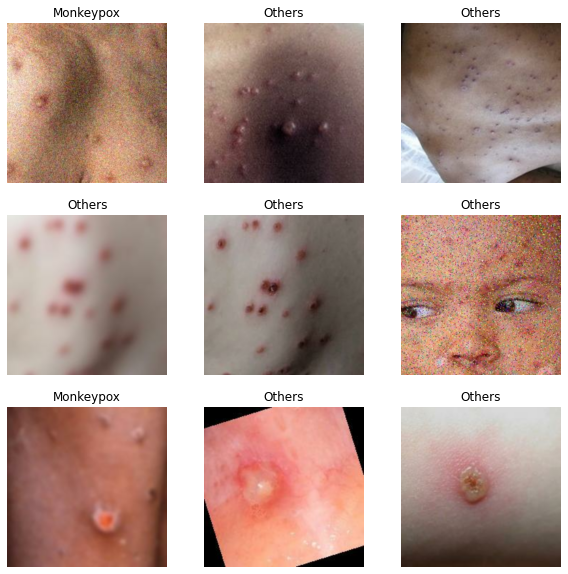

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 299, 299, 3)
(32,)


### Data Normalization

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.99971855


### Configuring the data for better performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the modified Xception model

In [9]:
from tensorflow.keras.layers import MaxPool2D

In [10]:
# Creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
              padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    return x   

In [11]:
# Creating separable Conv-batch norm block

def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters, kernel_size=kernel_size, strides=strides,
              padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)  
    return x  

In [12]:
# functions for Entry,Middle and Exit flow

def entry_flow(x):    
    x = conv_bn(x, filters = 32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters = 64, kernel_size =3, strides=1)
    tensor =ReLU()(x)
    x = sep_bn(tensor, filters=128, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(tensor, filters=128, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides=2, padding="same")(x)      
    tensor = conv_bn(tensor, filters=128, kernel_size=1, strides=2)
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size = 3)
    x =ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding = "same")(x)    
    tensor=conv_bn(tensor,filters=256, kernel_size=1, strides=2)
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size = 3)
    x =ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding = "same")(x)
    tensor = conv_bn(tensor,filters=728, kernel_size=1, strides=2)
    x = Add()([tensor, x])
    return x

In [13]:
# middle flow

def middle_flow(tensor):
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size = 3)
        x = ReLU()(x)
        tensor =Add()([tensor, x])
    return tensor    

In [14]:
# exit flow
def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=728, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters=1024, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides=2, padding="same")(x)
    tensor = conv_bn(tensor, filters=1024, kernel_size=1, strides=2)
    x = Add()([tensor, x])
    x = sep_bn(x, filters=1536, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters=2048, kernel_size = 3)
    x = ReLU()(x)  
    x = sep_bn(x, filters = 4096,  kernel_size=3)
    x = ReLU()(x) 
    x = GlobalAvgPool2D()(x)
    x = Dense (units = 2, activation ="softmax")(x)
        
    return x   

In [15]:
input = Input(shape = (299, 299, 3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

In [16]:
model =Model(inputs=input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 150, 150, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
lr = 0.001
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

In [18]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
    epochs=epochs,
   )          
  

Epoch 1/50
54/54 [==============================] - 47s 655ms/step - loss: 0.7521 - accuracy: 0.6184 - val_loss: 0.6929 - val_accuracy: 0.5526
Epoch 2/50
54/54 [==============================] - 33s 614ms/step - loss: 0.6237 - accuracy: 0.6534 - val_loss: 0.6929 - val_accuracy: 0.5526
Epoch 3/50
54/54 [==============================] - 33s 614ms/step - loss: 0.5979 - accuracy: 0.6750 - val_loss: 0.6927 - val_accuracy: 0.5526
Epoch 4/50
54/54 [==============================] - 33s 614ms/step - loss: 0.5651 - accuracy: 0.7007 - val_loss: 0.6916 - val_accuracy: 0.5526
Epoch 5/50
54/54 [==============================] - 33s 614ms/step - loss: 0.4984 - accuracy: 0.7550 - val_loss: 0.6855 - val_accuracy: 0.5526
Epoch 6/50
54/54 [==============================] - 33s 614ms/step - loss: 0.4263 - accuracy: 0.8046 - val_loss: 0.6618 - val_accuracy: 0.6491
Epoch 7/50
54/54 [==============================] - 33s 613ms/step - loss: 0.3292 - accuracy: 0.8571 - val_loss: 0.5950 - val_accuracy: 0.6623